In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from utils import misc


df = pd.read_csv('datasets/daily_price_series/SPY.csv')
df = misc.clean_df(df)
df = df.set_index('date')
df

,open,high,low,close,adjclose,volume,ticker
date,,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,25.122364,1003200,SPY
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.301012,480500,SPY
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.354612,201300,SPY
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.622643,529400,SPY
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.729851,531500,SPY
...,...,...,...,...,...,...,...
2023-05-02,414.769989,414.820007,407.820007,410.839996,410.839996,103998500,SPY
2023-05-03,411.359985,413.869995,407.769989,408.019989,408.019989,91531800,SPY
2023-05-04,406.929993,407.269989,403.739990,405.130005,405.130005,94901900,SPY


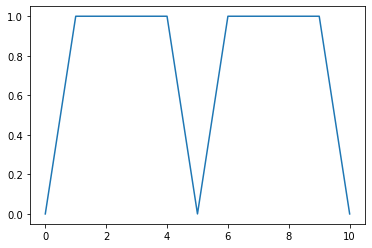

array([ 1,  0,  0,  0, -1,  1,  0,  0,  0, -1])

In [115]:
def generate_random_orders(length, threshold=0.1):
    random_positions = np.array([0 if f <= threshold else 1 for f in np.random.rand(length - 1)])
    random_positions = np.insert(random_positions, 0, 0)
    random_positions = np.insert(random_positions,len(random_positions), 0)
    plt.plot(random_positions)
    plt.show()
    random_orders = random_positions[1:] - random_positions[:-1]
    assert len(random_orders) == length
    return random_orders

generate_random_orders(10)

            Unnamed: 0        open        high         low       close  \
date                                                                     
1993-01-29           0   43.968750   43.968750   43.750000   43.937500   
1993-02-01           1   43.968750   44.250000   43.968750   44.250000   
1993-02-02           2   44.218750   44.375000   44.125000   44.343750   
1993-02-03           3   44.406250   44.843750   44.375000   44.812500   
1993-02-04           4   44.968750   45.093750   44.468750   45.000000   
...                ...         ...         ...         ...         ...   
2023-05-02        7618  414.769989  414.820007  407.820007  410.839996   
2023-05-03        7619  411.359985  413.869995  407.769989  408.019989   
2023-05-04        7620  406.929993  407.269989  403.739990  405.130005   
2023-05-05        7621  408.910004  413.720001  408.640015  412.630005   
2023-05-08        7622  412.970001  413.100006  411.679993  412.659393   

              adjclose     volume tic

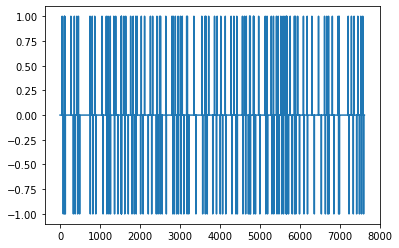

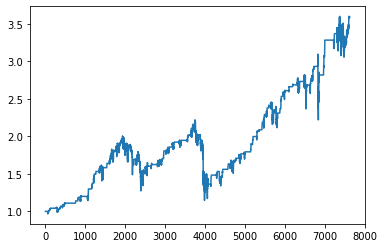

In [141]:
class trade:
    def __init__(self, entry_date, entry_price, quantity):
        self.entry_date = entry_date
        self.entry_price = entry_price
        self.quantity = quantity
        self.is_open = True
        if quantity > 0:
            self.is_long = True
        else:
            self.is_long = False
    
    def close(self, exit_date, exit_price):
        self.exit_date = exit_date
        self.exit_price = exit_price
        self.is_open = False

    def calculate_stats(self):
        pass

    

class backtester:
    def __init__(self, **kwargs) -> None:
        self.df = None
        self.initial_capital = misc.get_attr(kwargs, 'initial_capital', 1E6)
        self.reward_function = misc.get_attr(kwargs, 'reward_function', None)

        
        self.clean_slate()

        


    def clean_slate(self):
        '''
        Set initial default state of environment.
        Called by __init__ and reset
        '''
        # State variables
        self.cash = self.initial_capital
        self.position = 0
        self.position_value = 0
        self.portfolio_value = self.cash + self.position_value
        self.leverage = abs(self.position_value / self.portfolio_value)
        self.portfolio_volatility = 0
        self.portfolio_return = 1
        self.end = False
        self.current_step = 0
        self.open_trade = None

        # record all instantaneous values of state
        self.record = {
            'cash': [],
            'position': [],
            'position_value': [],
            'portfolio_value': [],
            'leverage': [],
        }

        # record all trades
        self.trade_record = []

        # instantaneous state of the trader
        self.trader_state = np.array([
            self.cash,
            self.position,
            self.position_value,
            self.portfolio_value,
            # self.leverage,
        ])



    def set_asset(self, ticker=None, df_path=None, update=False):
        if ticker is None:
            self.df = pd.read_csv(df_path)
        else:
            try:
                self.df = pd.read_csv('datasets/daily_price_series/'+ ticker +'.csv')
            except FileNotFoundError:
                pass
            if self.df is None or update:
                self.df = misc.get_price_data(ticker)
        
        # self.df = misc.clean_df(self.df)
        self.df = self.df.set_index('date')

        # self.df = self.df[-500:]

        self.open = self.df['open'].to_numpy()
        self.high = self.df['high'].to_numpy()
        self.low = self.df['low'].to_numpy()
        self.close = self.df['close'].to_numpy()
        self.adjclose = self.df['adjclose'].to_numpy()
        self.date = self.df.index.to_list()



    def take_action(self, order_quantity=0, order_price=0, order_type='market_on_close'):
        execution_price = 0
        execution_quantity = 0
        # price at which to evaluate position
        evaluation_price = self.adjclose[self.current_step]
        if order_quantity == 0:
            pass
        else:
            if order_type == 'market_on_close':
                execution_price = self.adjclose[self.current_step]
                execution_quantity = order_quantity
            

            if self.open_trade == None:
                assert self.position == 0, 'no open trades but position != 0'
                # opening new trade
                self.cost_basis = execution_price
                self.open_trade = trade(self.date[self.current_step], execution_price, execution_quantity)
            else:
                # close trade
                self.open_trade.close(self.date[self.current_step], execution_price)
                self.trade_record.append(self.open_trade)
                self.open_trade = None

                # open new trade on the same day if necessary
                if self.position + execution_quantity != 0:
                    self.open_trade = trade(self.date[self.current_step], execution_price, execution_quantity + self.position)
                
            
            self.position += execution_quantity
            self.cash -= execution_price * execution_quantity

        # calculate new trader state
        self.position_value = self.position * evaluation_price
        self.portfolio_value = self.cash + self.position_value
        self.leverage = abs(self.position_value / self.portfolio_value)
        if self.portfolio_volatility == np.nan:
            self.portfolio_volatility = 0

        self.trader_state = np.array([
            self.cash,
            self.position,
            self.position_value,
            self.portfolio_value,
            # self.leverage,
            # self.portfolio_volatility,
        ])

        # record
        self.record['cash'].append(self.cash)
        self.record['position'].append(self.position)
        self.record['position_value'].append(self.position_value)
        self.record['portfolio_value'].append(self.portfolio_value)
        self.record['leverage'].append(self.leverage)

        self.current_step += 1


    
bt = backtester()
bt.set_asset('SPY')

df = bt.df.copy()
df['signal'] = df['close'].rolling(13).mean() - df['close'].rolling(48).mean()
df['signal+1'] = df['signal'].shift(1)

trade_list = []
for i in range(len(df)):
    if df['signal'][i] < 0 and df['signal+1'][i] > 0:
        trade_list.append(1)
    elif df['signal'][i] > 0 and df['signal+1'][i] < 0:
        trade_list.append(-1)
    else:
        trade_list.append(0)

df['trade_list'] = trade_list

print(df)

plt.plot(trade_list)
plt.show()

for i in trade_list:
    if bt.open_trade == None:
        order_quantity = (bt.cash // bt.adjclose[bt.current_step]) * trade_list[bt.current_step]
    else:
        order_quantity = bt.position * trade_list[bt.current_step]

    bt.take_action(order_quantity=order_quantity)

port_val = np.array(bt.record['portfolio_value']) / 1e6
pos = np.array(bt.record['position'])

# plt.plot(pos)

plt.plot(port_val)